In [1]:
!pip install wfdb
import wfdb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
cwd = os.getcwd()
print("Current Working Directory:", cwd)

Current Working Directory: /content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/Course_work')
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/MyDrive/Course_work


In [5]:
data_dir = './mit-bih-arrhythmia-database-1.0.0'

In [6]:
open(os.path.join(data_dir, 'RECORDS'))

<_io.TextIOWrapper name='./mit-bih-arrhythmia-database-1.0.0/RECORDS' mode='r' encoding='utf-8'>

In [7]:
with open(os.path.join(data_dir, 'RECORDS'), 'r') as f:
    records = [line.strip() for line in f]

In [8]:
label_decode = {
    'N': 0,
    'L': 1,
    'R': 2,
    'A': 3,
    'V': 4,
    '/': 5
}

In [9]:
all_beats = []
for rec in records:
    record = wfdb.rdrecord(os.path.join(data_dir, rec))
    annotation = wfdb.rdann(os.path.join(data_dir, rec), 'atr')
    fs = record.fs
    signal = record.p_signal[:, 0]
    r_peaks = annotation.sample
    labels = annotation.symbol
    window_before = int(0.2 * fs)
    window_after = int(0.4 * fs)



    beats, beat_labels = [], []
    for i, r in enumerate(r_peaks):
        if r > window_before and r + window_after < len(signal):
            segment = signal[r - window_before : r + window_after]
            beats.append(segment)
            beat_labels.append(labels[i])

    df = pd.DataFrame(beats)
    df['label'] = beat_labels
    df['target'] = df['label'].map(label_decode)
    df['record'] = rec
    all_beats.append(df)

final_df = pd.concat(all_beats, ignore_index=True)
final_df.to_csv('mitbih_beat_dataset.csv', index=False)


In [10]:
final_df = final_df.dropna(subset=['target'])
final_df['target'] = final_df['target'].astype(int)

In [11]:
final_df.label.value_counts(), final_df.target.value_counts()

(label
 N    75028
 L     8072
 R     7255
 V     7129
 /     7027
 A     2546
 Name: count, dtype: int64,
 target
 0    75028
 1     8072
 2     7255
 4     7129
 5     7027
 3     2546
 Name: count, dtype: int64)

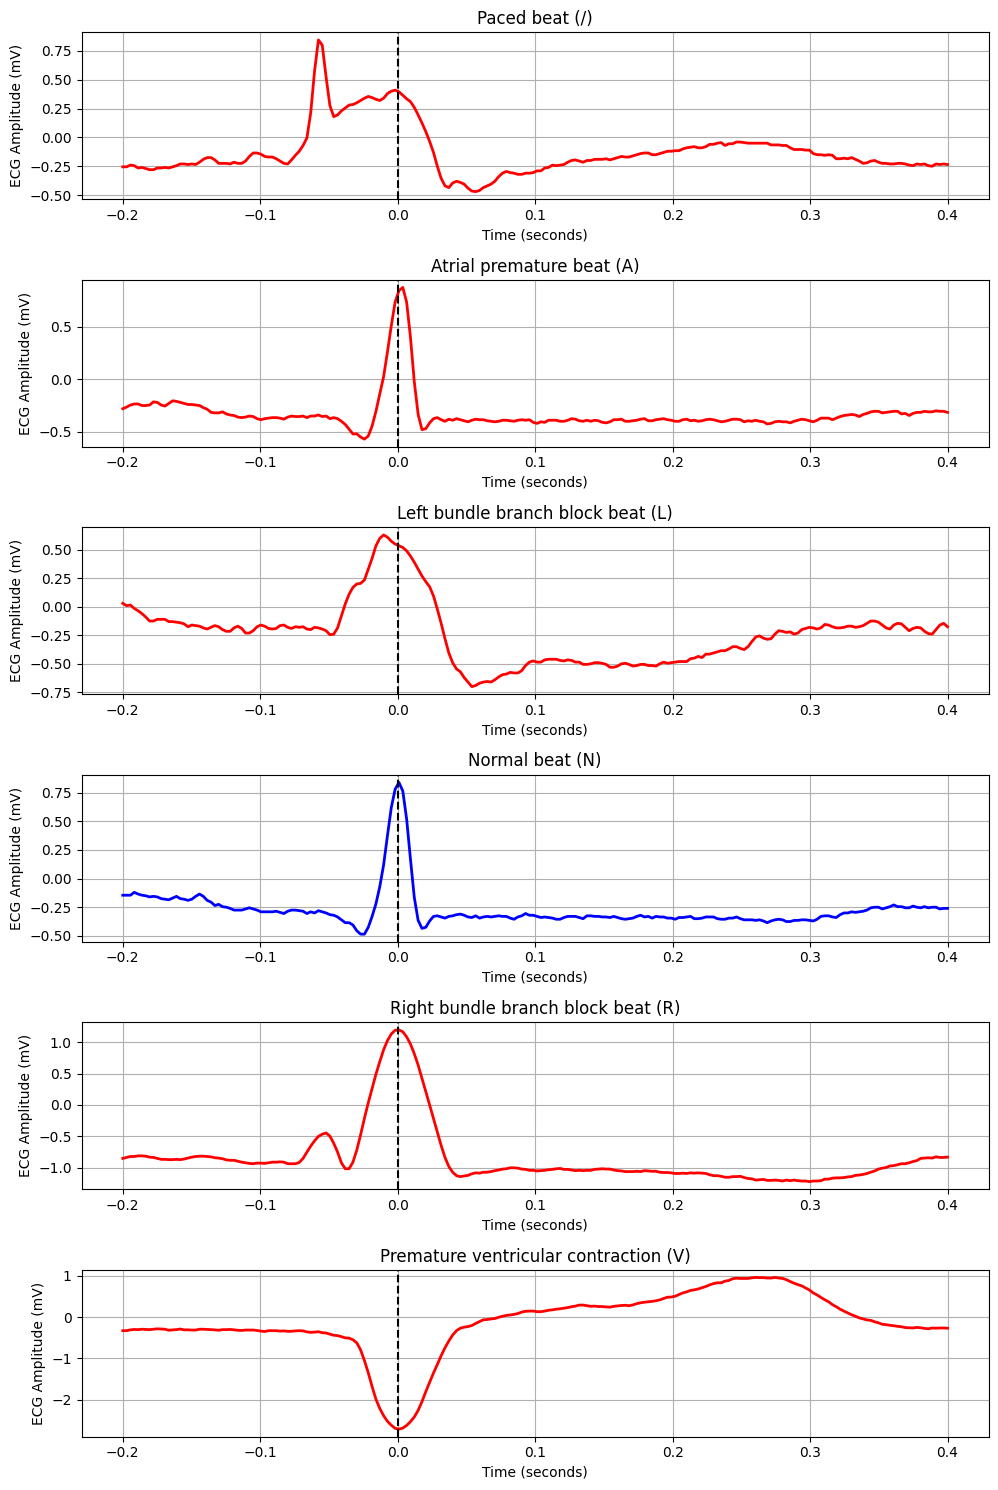

In [12]:

record_names = [
    '100','101','102','103','104','105','106','107','108','109',
    '111','112','113','114','115','116','117','118','119','121',
    '122','123','124',
    '200','201','202','203','205','207','208','209','210','212',
    '213','214','215','217','219','220','221','222','223','228',
    '230','231','232','233','234'
]

symbol_description = {
    'N': 'Normal beat',
    'L': 'Left bundle branch block beat',
    'R': 'Right bundle branch block beat',
    'A': 'Atrial premature beat',
    'V': 'Premature ventricular contraction',
    '/': 'Paced beat',
}


target_symbols = ['N', 'L', 'R', 'A', 'V', '/']

# Sampling window around R-peak (assuming 360 Hz)
fs_default = 360
window_before = int(0.2 * fs_default)
window_after = int(0.4 * fs_default)

first_beats = {}

for rec_name in record_names:
    if len(first_beats) == len(target_symbols):
        break  # all found

    record_path = os.path.join(data_dir, rec_name)
    try:
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
    except Exception as e:
        print(f"Skipping record {rec_name}: {e}")
        continue

    fs = record.fs
    signal = record.p_signal[:, 0]  # MLII
    r_peaks = annotation.sample
    labels = annotation.symbol

    for sym in target_symbols:
        if sym in first_beats:
            continue

        # first occurrence of this symbol in this record
        try:
            idx = next(i for i, l in enumerate(labels) if l == sym)
        except StopIteration:
            continue

        r = r_peaks[idx]
        if r - window_before < 0 or r + window_after > len(signal):
            continue

        beat = signal[r - window_before : r + window_after]
        time = np.linspace(-0.2, 0.4, len(beat))
        first_beats[sym] = (time, beat)

if not first_beats:
    raise ValueError("No target beats found in any record.")

# Plot: normal in blue, others in red, titles with full names
n_beats = len(first_beats)
plt.figure(figsize=(10, 2.5 * n_beats))

for i, sym in enumerate(sorted(first_beats.keys()), start=1):
    time, beat = first_beats[sym]
    color = 'blue' if sym == 'N' else 'red'
    full_name = symbol_description.get(sym, f"Symbol {sym}")
    plt.subplot(n_beats, 1, i)
    plt.plot(time, beat, color=color, linewidth=2)
    plt.axvline(0, color='k', linestyle='--')
    plt.title(f'{full_name} ({sym})')
    plt.xlabel('Time (seconds)')
    plt.ylabel('ECG Amplitude (mV)')
    plt.grid(True)

plt.tight_layout()
plt.show()
